# **Handwritten Digit Classification: Evaluating and Comparing NN Architectures**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Curabitur tempor magna sed arcu sagittis bibendum. Phasellus accumsan et diam sit amet dictum. Phasellus scelerisque bibendum ex a malesuada. Vivamus auctor libero eget lacus venenatis aliquam. Aenean elementum eros vel ex finibus tincidunt. Pellentesque ut leo sapien. Quisque sodales, elit eu malesuada aliquet, erat risus gravida ipsum, ac aliquet libero mauris in lorem. Nulla facilisi. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos.

**Authors:**
- [Andrea Ramírez](https://github.com/Andrea-gt)
- [Adrian Flores](https://github.com/adrianRFlores)

***

## **Import Libraries** ⬇️

In [12]:
#!pip install keras-tuner

In [13]:
#%pip install kaggle

In [14]:
#!pip install opendatasets

In [1]:
# Standard libraries
import os
import zipfile
import shutil
import warnings
import itertools
from operator import concat
from PIL import Image
import cv2

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow import keras
import opendatasets as od

# Suppress warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (10, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

# Set TensorFlow Global Seed
tf.random.set_seed(random_state)

## **Data Upload** 📄

In [2]:
# Check if the directory 'mnist-multiple-dataset-comprehensive-analysis' exists
if not os.path.isdir('mnist-multiple-dataset-comprehensive-analysis'):
    # If the directory doesn't exist, download the dataset from Kaggle
    od.download("https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis?resource=download")
else:
    # If the directory exists, copy the contents of 'train' into '../Scripts/mnist-dataset/train'
    train_src = 'mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train'
    train_dst = '../Scripts/mnist-dataset/train'
    if not os.path.exists(train_dst):
        shutil.copytree(train_src, train_dst)

    # Copy the contents of 'test' into '../Scripts/mnist-dataset/test'
    test_src = 'mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test'
    test_dst = '../Scripts/mnist-dataset/test'
    if not os.path.exists(test_dst):
        shutil.copytree(test_src, test_dst)

In [3]:
def load_images_with_labels(directory):
    """
    Load images and their labels from the specified directory and its subdirectories.

    Parameters:
    - directory (str): Path to the main directory containing subdirectories with images.

    Returns:
    - List of tuples: Each tuple contains the image path and its corresponding label.
    """
    image_label_pairs = []

    # List all subdirectories in the directory
    subdirs = [os.path.join(directory, subdir) for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]

    for subdir in subdirs:
        # Collect all image files in the current subdirectory
        all_files = os.listdir(subdir)
        image_files = [os.path.join(subdir, f) for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        # Extract label from the image filename (remove extension)
        for image_file in image_files:
            label = os.path.splitext(os.path.basename(image_file))[0]
            label = label.split('.')[1]
            image_label_pairs.append((image_file, label))

    return image_label_pairs

In [4]:
def load_and_display_images_with_labels(directory, num_images=5):
    """
    Load and display a sample of images with their labels from the specified directory and its subdirectories.

    Parameters:
    - directory (str): Path to the main directory containing subdirectories with images.
    - num_images (int): Number of images to display.
    """
    # Load image-label pairs
    image_label_pairs = load_images_with_labels(directory)

    # Display a sample of images
    for i, (image_file, label) in enumerate(image_label_pairs[:num_images]):
        with Image.open(image_file) as img:
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Label {label}")
            plt.axis('off')

    plt.show()
    return image_label_pairs

Displaying training images...


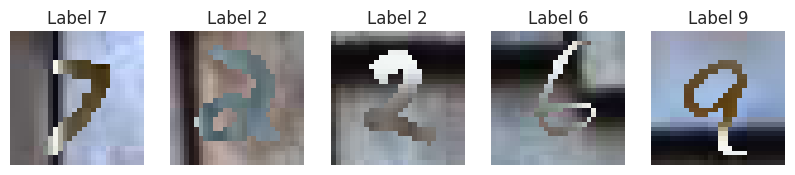

Displaying test images...


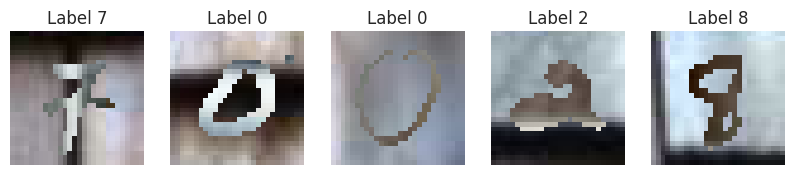

In [5]:
# Define paths to the train and test directories
train_dir = '../Scripts/mnist-dataset/train'
test_dir = '../Scripts/mnist-dataset/test'

# Load and display images from the train directory
print("Displaying training images...")
train = load_and_display_images_with_labels(train_dir)

# Load and display images from the test directory
print("Displaying test images...")
test = load_and_display_images_with_labels(test_dir)

**Observaciones 💡 -->**

> - El conjunto de datos MNIST Multiple Dataset for Comprehensive Analysis se ha obtenido desde la página oficial de [Kaggle](https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis?resource=download). En particular, se ha utilizado la variante PolyMNIST, que incluye cinco modalidades distintas. En cada modalidad, el fondo está compuesto por parches aleatorios extraídos de una imagen más grande, con un dígito colocado de manera aleatoria dentro de estos parches. Esta configuración proporciona a cada modalidad información única del fondo, mientras que el dígito actúa como información compartida entre todas las modalidades.

> - Como se puede observar en los resultados del código anterior, todas las imágenes tienen la misma resolución, así que no se deben de modificar en este aspecto.

## **Exploratory Analysis** 🔎

In [6]:
# Example of converting lists of tuples to DataFrames
def convert_to_dataframe(data_list):
    # Create lists to hold images and labels
    images = []
    labels = []

    # Iterate through the list of tuples
    for image, label in data_list:
        images.append(image)
        labels.append(label)

    # Convert lists to DataFrame
    df = pd.DataFrame({
        'image': images,
        'label': labels
    })

    return df

In [7]:
# Convert the train and test lists to DataFrames
dataframes = [convert_to_dataframe(train), convert_to_dataframe(test)]

In [8]:
# Display the DataFrames
for i, df in enumerate(dataframes):
  print("Training DataFrame:" if i == 0 else "Test DataFrame:")
  print(df.head(), "\n")

Training DataFrame:
                                          image label
0   ../Scripts/mnist-dataset/train/m4/756.7.png     7
1  ../Scripts/mnist-dataset/train/m4/4740.2.png     2
2  ../Scripts/mnist-dataset/train/m4/1342.2.png     2
3  ../Scripts/mnist-dataset/train/m4/1190.6.png     6
4  ../Scripts/mnist-dataset/train/m4/1805.9.png     9 

Test DataFrame:
                                        image label
0  ../Scripts/mnist-dataset/test/m4/756.7.png     7
1   ../Scripts/mnist-dataset/test/m4/37.0.png     0
2   ../Scripts/mnist-dataset/test/m4/72.0.png     0
3  ../Scripts/mnist-dataset/test/m4/299.2.png     2
4  ../Scripts/mnist-dataset/test/m4/419.8.png     8 



### **(1) Exploración y Limpieza Inicial de los Datos**

In [23]:
for i, df in enumerate(dataframes):
    # Get the number of rows in the DataFrame
    rows_num = df.shape[0]
    # Print the number of records in the DataFrame
    print(f"{'Training DataFrame:' if i == 0 else 'Test DataFrame:'} has {rows_num} records.")

Training DataFrame: has 300000 records.
Test DataFrame: has 50000 records.


**Observaciones 💡 -->**

> - El primer conjunto de datos, el que será utilizado para el **entrenamiento** del modelo, cuenta con alrededor de 300.000 registros y 2 columnas.
> - El primer conjunto de datos, el que será utilizado para el **testeo** del modelo, cuenta con alrededor de 50.000 registros y 2 columnas.

In [24]:
for df in dataframes:
  # Basic information about the dataset
  print(df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   image   300000 non-null  object
 1   label   300000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   50000 non-null  object
 1   label   50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None 



In [25]:
for df in dataframes:
  # Basic information about the dataset
  df['label'] = df['label'].astype(int)

### **(2) Clasificación de las Variables**

| Nombre | Descripción                                                                 | Tipo               |
|--------|-----------------------------------------------------------------------------|--------------------|
| image  | Contiene las imágenes de dígitos en formato de objeto.| Categórica (Descriptiva) |
| label  | Contiene las etiquetas asociadas a cada imagen, que representan el dígito correspondiente en formato de objeto. | Categórica (Descriptiva) |

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Distribución de Labels**

In [26]:
def labelDistribution(df, name):
  label_counts = df['label'].value_counts().sort_index()
  total_counts = label_counts.sum()

  # Calculate percentages
  label_percentages = (label_counts / total_counts) * 100
  # Plot counts
  plt.subplot(1, 2, 1)
  label_counts.plot(kind='bar', color=palette[0])
  plt.title(f'{name}: Label Counts')
  plt.xlabel('Label')
  plt.ylabel('Count')

  # Plot percentages
  plt.subplot(1, 2, 2)
  label_percentages.plot(kind='bar', color=palette[4])
  plt.title(f'{name}: Label Percentages')
  plt.xlabel('Label')
  plt.ylabel('Percentage (%)')

  plt.tight_layout()
  plt.show()

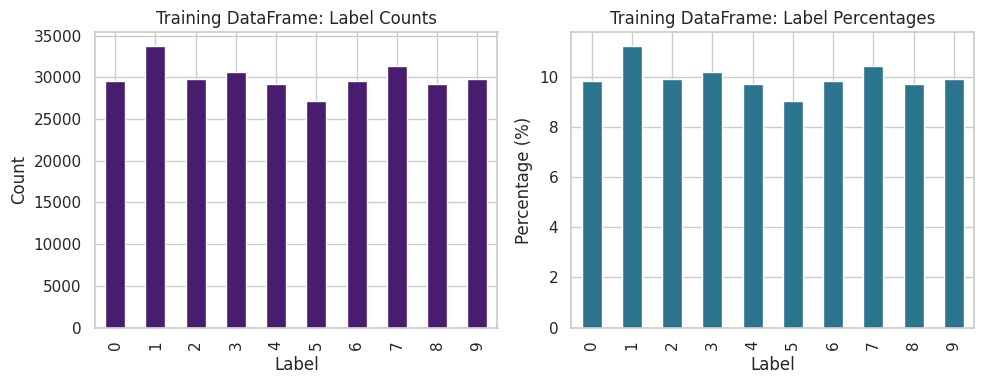

In [27]:
labelDistribution(dataframes[0], "Training DataFrame")

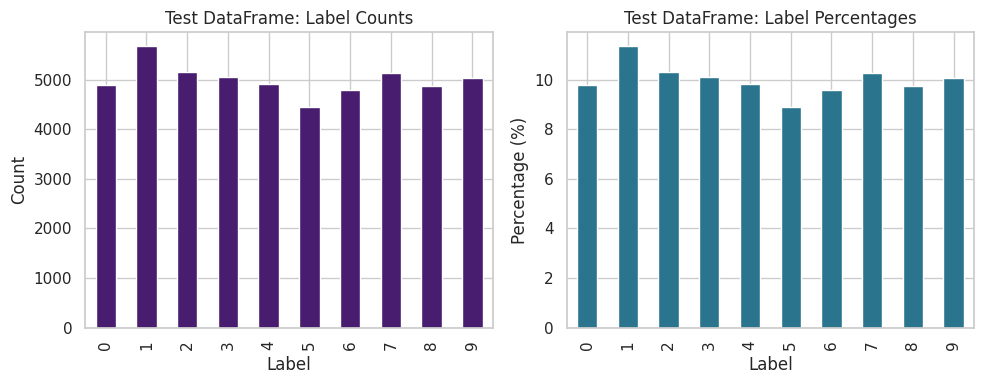

In [28]:
labelDistribution(dataframes[1], "Test DataFrame")

**Observaciones 💡 -->**

> - En el conjunto de datos, tanto para las muestras de entrenamiento como para las de prueba, la mayoría de las clases representan aproximadamente el 10% del total. Esto indica que las clases están moderadamente balanceadas. Este equilibrio es crucial para los modelos que generaremos porque asegura que cada clase tenga una representación adecuada durante el entrenamiento y la evaluación.

> - Recordemos que un conjunto de datos balanceado facilita el aprendizaje equitativo de todas las clases, lo que a su vez ayuda a evitar sesgos hacia las clases más frecuentes Además, un conjunto de datos balanceado mejora la capacidad del modelo para identificar patrones y características distintivas de cada clase, lo que resulta en una mayor precisión y robustez en la clasificación.

> - Se observa que la clase 1 está sobrerrepresentada en comparación con el resto de clases para ambos conjuntos de datos. Por otro lado, la clase que cuenta con menos representación es la clase 5. Este desequilibrio puede tener un impacto en el rendimiento del modelo, ya que el modelo podría aprender a predecir la clase 1 con mayor facilidad y precisión y tener problemas tratando de clasificar correctamente la clase 5.

Para abordar este problema, se podrían considerar técnicas de ajuste del balance de clases. Sin embargo, dado que el desequilibrio no es tan drástico, se evaluará primero el comportamiento de los modelos con el conjunto de datos actual antes de tomar una decisión sobre la aplicación de técnicas de balanceo.

#### **(2) Tamaños de Imagenes**

In [29]:
 # Get unique image sizes
for i, df in enumerate(dataframes):
  # Extract image sizes
  sizes = df['image'].apply(lambda path: Image.open(path).size if isinstance(path, str) else (None, None))
  # Count unique sizes
  size_counts = sizes.value_counts()
  print(f'Training DataFrame:' if i == 0 else 'Test DataFrame:')
  for size, count in size_counts.items():
    print(f'Size {size}: Count = {count}')
    print()

Training DataFrame:
Size (28, 28): Count = 300000

Test DataFrame:
Size (28, 28): Count = 50000



**Observaciones 💡 -->**

> - Observamos que no es necesario realizar un reescalado de las imágenes, ya que todas ellas tienen las mismas dimensiones (28x28) tanto en el conjunto de datos de prueba como en el de entrenamiento.

## **Image Preprocessing 📷**

In [9]:
def preprocess_image(image_path, taget_size = 28):
    # Read the image from the file
    img = cv2.imread(image_path)
    # Convert the image to grayscale (if required by your model)
    # If your CNN expects color images, skip this step
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Reason: Convert to grayscale if the model is designed for single-channel input.
    # Normalize pixel values to the range [0, 1]
    img = img / 255.0
    # Reason: Normalization ensures that pixel values are in a consistent range, helping the CNN learn more effectively.
    # Apply Gaussian blur to reduce noise (optional, depending on the noise level in your images)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Reason: Noise reduction can help the CNN by removing small details that may not be useful for learning.
    img = np.expand_dims(img, axis=-1)
    # Reason: Consistent image size is required for CNN input.

    return img

In [10]:
# Put labels into y_train variable
y_train = dataframes[0]['label']
# Drop 'label' column
x_train = dataframes[0].drop(labels = ['label'], axis = 1)

In [11]:
# Drop 'label' column
test_df = dataframes[1].drop(labels = ['label'], axis = 1)

In [12]:
# Apply the function
x_train['image'] = x_train['image'].apply(preprocess_image)

In [13]:
# Apply the function
test_df['image'] = test_df['image'].apply(preprocess_image)

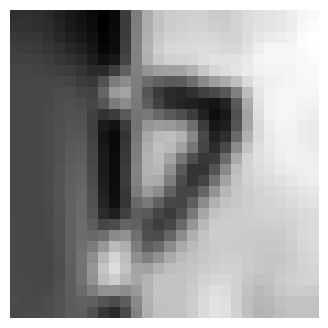

In [14]:
image = x_train['image'][0]  # Select the first image
# Display the image
plt.imshow(image.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Hide axis labels
plt.show()

**Observaciones 💡 -->**

1. **Conversión a Escala de Grises**
   - **Código**: `img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`
   - **Descripción**: Convierte la imagen de color (BGR) a una imagen en escala de grises.
   - **Propósito**: Reducir la complejidad del modelo ya que se espera una entrada de un solo canal (grayscale). Permitirá que el entrenamiento sea más rápido.

2. **Normalización de Valores de Pixel**
   - **Código**: `img = img / 255.0`
   - **Descripción**: Normaliza los valores de los píxeles a un rango de [0, 1].
   - **Propósito**: Normalizar los valores de los píxeles asegura que estén en un rango consistente, lo que ayuda a mantener una iluminación y contraste uniformes en todas las imágenes. Esto facilita la comparación de patrones y características, haciendo que las imágenes sean más adecuadas para el análisis. Además, permite que los modelos de aprendizaje automático aprendan patrones de manera más efectiva, sin que las diferencias en las condiciones de iluminación afecten el rendimiento.

3. **Aplicación de Desenfoque Gaussiano**
   - **Código**: `img = cv2.GaussianBlur(img, (5, 5), 0)`
   - **Descripción**: Aplica un filtro de desenfoque gaussiano para reducir el ruido en la imagen.
   - **Propósito**: El desenfoque gaussiano reduce el detalle y el ruido en la imagen aplicando una función gaussiana a cada píxel y sus píxeles circundantes. Esto suaviza los bordes y elimina pequeños detalles que pueden no ser útiles para el aprendizaje, ayudando a la red neuronal a centrarse en las características más relevantes. La reducción de ruido mejora la capacidad de generalización del modelo y puede facilitar tareas como la detección de bordes o la segmentación al reducir las variaciones no deseadas en la imagen.

4. **Expansión de Dimensiones**
   - **Código**: `img = np.expand_dims(img, axis=-1)`
   - **Descripción**: Expande las dimensiones de la imagen para agregar un canal adicional.
   - **Propósito**: Asegura que la imagen tenga un formato consistente para la entrada de la red neuronal, especialmente si la red espera una entrada con un número específico de canales (por ejemplo, [alto, ancho, canales]).

**Referencia**
> - https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c

In [15]:
# Label Encoding
from keras.utils import to_categorical # Convert to one-hot-encoding
y_train = to_categorical(y_train, num_classes = 10)

In [16]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

**Observaciones 💡 -->**

> - Se utiliza la función to_categorical de Keras para convertir las etiquetas de entrenamiento y_train en una representación de codificación one-hot. Esto transforma cada etiqueta en un vector binario, donde la posición correspondiente a la clase de la etiqueta se establece en 1 y todas las demás posiciones se establecen en 0.

## **CNN Model Generation (DL Approach)**

In [17]:
x_train_reshape = np.array([np.array(img) for img in x_train['image']])
test_reshape = np.array([np.array(img) for img in test_df['image']])

In [18]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train_reshape, y_train, test_size = 0.2, random_state = random_state)

In [19]:
print("x_train shape", X_train.shape)
print("x_test shape", X_val.shape)
print("y_train shape", Y_train.shape)
print("y_test shape", Y_val.shape)

x_train shape (240000, 28, 28, 1)
x_test shape (60000, 28, 28, 1)
y_train shape (240000, 10)
y_test shape (60000, 10)


### **(1) Modelo 1**

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [ ]:
model = Sequential()
#
model.add(Conv2D(filters=8, kernel_size=(5, 5), padding='same',
                 activation='relu', input_shape=(28, 28, 1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
#
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.25))

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [21]:
# Define the optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
# Compile the model
model.compile(optimizer = opt, loss = "categorical_crossentropy" , metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,906 (800.41 KB)

 Trainable params: 204,906 (800.41 KB)

 Non-trainable params: 0 (0.00 B)

**Observaciones 💡 -->**

El primer modelo es una red neuronal convolucional (CNN) definida usando el enfoque secuencial de Keras. Comienza con una capa convolucional que extrae características iniciales de imágenes en escala de grises de 28x28 píxeles, seguida de una capa de max pooling para reducir la dimensionalidad. Luego, se aplica dropout para prevenir el sobreajuste. La red continúa con una segunda capa convolucional y otra capa de max pooling, cada una seguida de dropout adicional. Las características extraídas se aplanan y se procesan a través de una capa densa con 256 neuronas, seguida de una capa de dropout para regularización adicional. Finalmente, se agrega una capa densa de salida con 10 neuronas y activación softmax para clasificar las imágenes en 10 categorías. El modelo se compila usando el optimizador Adam y la función de pérdida categorical_crossentropy.

In [22]:
epochs = 5  # For better result increase the epochs
batch_size = 32

In [37]:
# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_reshape)

**Observaciones 💡 -->**

 > - En esta sección se realiza **data augmentation** en el conjunto de datos de entrenamiento, con el objetivo de mejorar la capacidad de generalización del modelo. En este caso, la configuración especifica varias técnicas de aumento de datos: rotación aleatoria de imágenes hasta 5 grados, zoom aleatorio del 10%, desplazamientos horizontales y verticales de hasta 10%, y no se aplican inversiones horizontales ni verticales.
 > - **Data Aumentation** es el proceso de generar artificialmente nuevos datos a partir de datos existentes, principalmente para entrenar nuevos modelos de aprendizaje automático (ML). Este proceso permite que los modelos generalicen mejor en entornos reales. Estas técnicas reducen la dependencia de grandes volúmenes de datos, haciendo que conjuntos de datos pequeños sean más efectivos al complementarlos con puntos de datos sintéticos. Además, el aumento de datos mitiga el sobreajuste, evitando que los modelos se especialicen en un tipo específico de datos y mejorando su capacidad para manejar datos nuevos [Referencia](https://aws.amazon.com/what-is/data-augmentation/)

<div class="alert alert-block alert-warning">
<b>Importante:</b> Por favor notar que en todos los modelos se implementará data augmentation.</div>

#### **(1) Entrenamiento**

In [ ]:
# Fit the model
history = model.fit(datagen.flow(x_train_reshape, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 392s 42ms/step - accuracy: 0.5093 - loss: 1.4193 - val_accuracy: 0.8170 - val_loss: 0.6100
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 443s 42ms/step - accuracy: 0.6746 - loss: 0.9709 - val_accuracy: 0.8249 - val_loss: 0.5645
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 402s 43ms/step - accuracy: 0.7055 - loss: 0.8862 - val_accuracy: 0.8594 - val_loss: 0.4536
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 426s 41ms/step - accuracy: 0.7238 - loss: 0.8339 - val_accuracy: 0.8707 - val_loss: 0.4113
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 382s 41ms/step - accuracy: 0.7390 - loss: 0.7875 - val_accuracy: 0.8694 - val_loss: 0.4187


#### **(2) Evaluación de Desempeño**

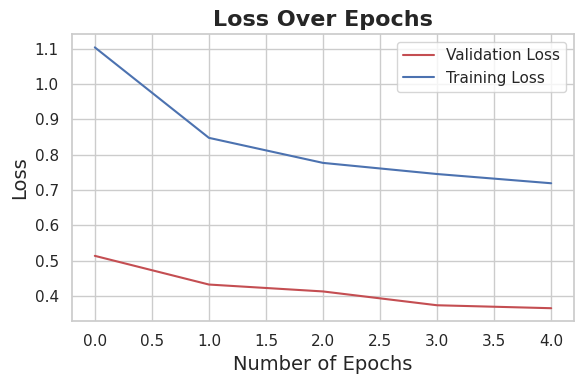

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

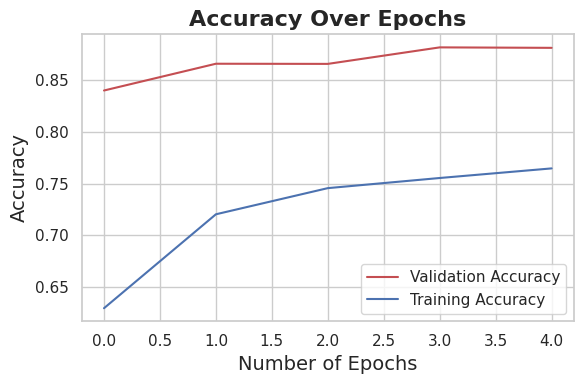

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
score = model.evaluate(X_val, Y_val, verbose = 0)
print('Accuracy over the validation set:', round((score[1]*100), 2), '%')

Accuracy over the validation set: 88.12 %


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step


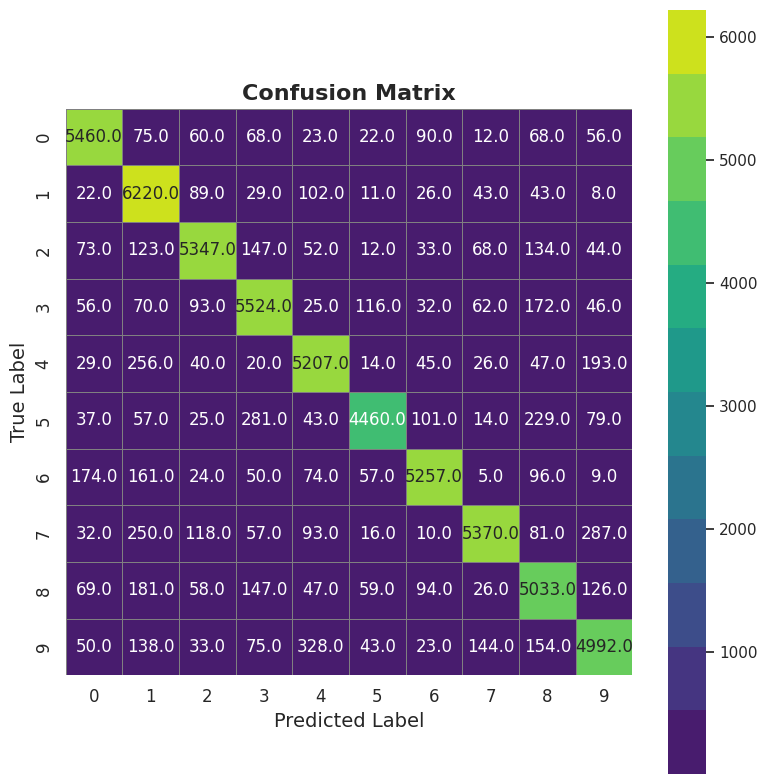

In [ ]:
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Create the plot
plt.figure(figsize=(8, 8))

# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)

# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

**Observaciones 💡 -->**

> - El modelo ha alcanzado una precisión del 88.12% en el conjunto de validación. Aunque esta métrica general es bastante buena, se observó que el modelo tiene dificultades específicas para clasificar la clase 5. Esta dificultad en la clasificación puede estar relacionada con el desbalance en el conjunto de datos que se mencionó en el análisis exploratorio, donde la clase 5 está subrepresentada en comparación con otras clases.

### **(2) Modelo 2**

In [22]:
from keras.layers import BatchNormalization

In [ ]:
# Initialize the model
second_model = Sequential()

# 1st Convolutional Block
second_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                 activation='relu', input_shape=(28, 28, 1)))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D(pool_size=(2, 2)))
second_model.add(Dropout(0.25))

# 2nd Convolutional Block
second_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D(pool_size=(2, 2)))
second_model.add(Dropout(0.25))

# Fully Connected Layers
second_model.add(Flatten())
second_model.add(Dense(128, activation='relu'))
second_model.add(Dropout(0.5))
second_model.add(Dense(10, activation='softmax'))

In [ ]:
# Compile the model
second_model.compile(optimizer = opt, loss = "categorical_crossentropy" , metrics=["accuracy"])

In [ ]:
second_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         200,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,114 (809.04 KB)

 Trainable params: 207,018 (808.66 KB)

 Non-trainable params: 96 (384.00 B)

**Observaciones 💡 -->**

El segundo modelo es una red neuronal convolucional que mejora la arquitectura anterior al incorporar capas de normalización por lotes (BatchNormalization). El modelo comienza con un bloque convolucional que incluye una capa convolucional con 16 filtros de tamaño 3x3 y una capa de normalización por lotes que sigue a la activación ReLU. Esto ayuda a estabilizar y acelerar el entrenamiento al normalizar las activaciones de la capa anterior. A continuación, se aplica max pooling y dropout para reducir la dimensionalidad y prevenir el sobreajuste.

El segundo bloque convolucional sigue un patrón similar, pero con 32 filtros, también incluye una capa de normalización por lotes y es seguido por max pooling y dropout. La sección de capas totalmente conectadas se ha reducido a 128 neuronas en comparación con las 256 neuronas del modelo anterior, lo que puede ayudar a mejorar la eficiencia del entrenamiento y reducir el riesgo de sobreajuste. La arquitectura anterior carecía de normalización por lotes, que puede mejorar significativamente la convergencia del modelo y su capacidad para manejar variaciones en los datos.

#### **(1) Entrenamiento**

In [ ]:
# Fit the model
history = second_model.fit(datagen.flow(x_train_reshape, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 492s 52ms/step - accuracy: 0.4874 - loss: 1.4816 - val_accuracy: 0.8362 - val_loss: 0.4981
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 496s 52ms/step - accuracy: 0.7390 - loss: 0.8007 - val_accuracy: 0.8851 - val_loss: 0.3491
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 504s 52ms/step - accuracy: 0.7711 - loss: 0.7067 - val_accuracy: 0.8950 - val_loss: 0.3292
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 484s 52ms/step - accuracy: 0.7856 - loss: 0.6617 - val_accuracy: 0.8997 - val_loss: 0.3288
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 503s 52ms/step - accuracy: 0.7943 - loss: 0.6386 - val_accuracy: 0.8832 - val_loss: 0.3618


#### **(2) Evaluación de Desempeño**

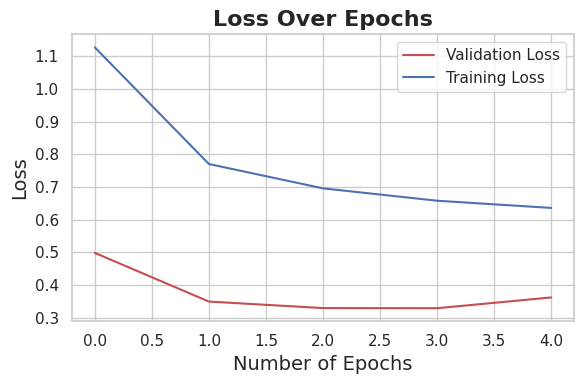

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

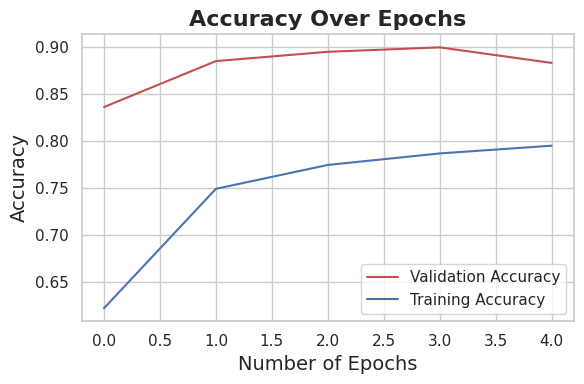

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
score = second_model.evaluate(X_val, Y_val, verbose = 0)
print('Accuracy over the validation set:', round((score[1]*100), 2), '%')

Accuracy over the validation set: 88.32 %


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step


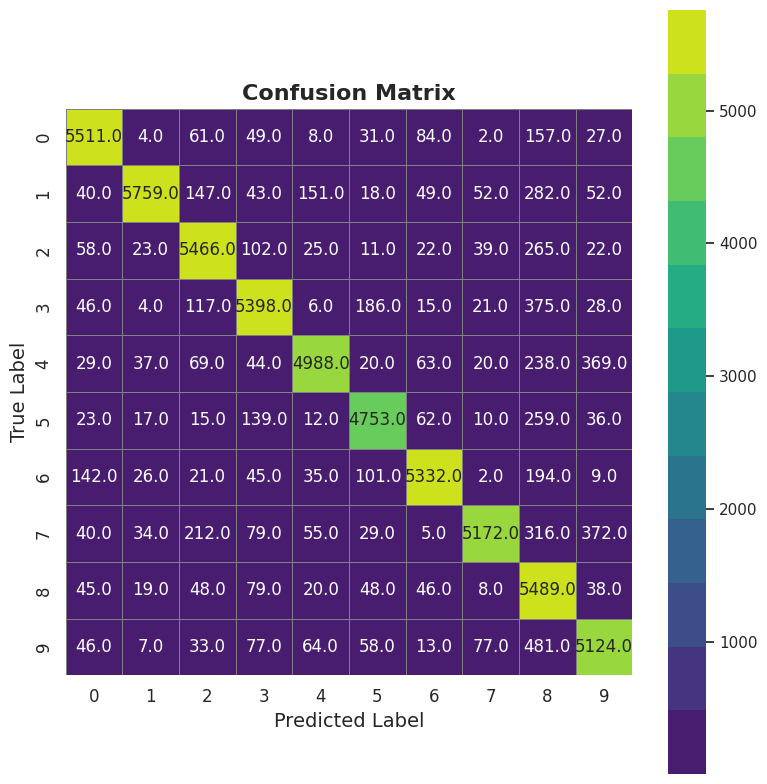

In [ ]:
# Predict the values from the validation dataset
Y_pred = second_model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Create the plot
plt.figure(figsize=(8, 8))

# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)

# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

> - El nuevo modelo muestra una ligera mejora en precisión (88.32% vs. 88.12%), indicando una mejor capacidad de generalización.

> - El modelo toma más tiempo en el entrenamiento debido a la mayor complejidad y el procesamiento adicional de la normalización por lotes.

> - Las gráficas de pérdida y precisión muestran un comportamiento más estable durante el entrenamiento, lo que sugiere que la normalización por lotes contribuye a una mejor convergencia.

Aunque el segundo modelo presenta una ligera mejora en precisión (88.32% frente a 88.12%), esta diferencia no es lo suficientemente significativa como para considerarlo **mejor** al modelo anterior. Además, el aumento en el tiempo de entrenamiento asociado con el segundo modelo, debido a la mayor complejidad en arquitectura, sugiere que el primer modelo sigue siendo la opción más óptima.

### **(2) Evaluación de Prediccion de Modelos Generados**

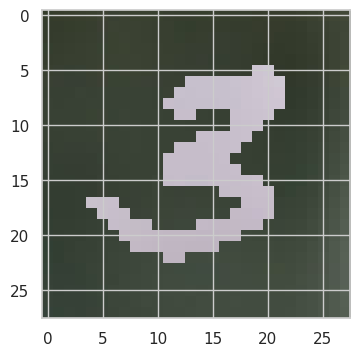

In [43]:
image_path = "../Scripts/mnist-dataset/test/m1/10.3.png"
img = cv2.imread(image_path)
plt.imshow(img)

In [44]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.expand_dims(img, axis=-1)
img = np.array([np.array(img)])
img.shape

(1, 28, 28, 1)

In [ ]:
# Example prediction and expected class
model_prediction = model.predict(img)
predicted_class = np.argmax(model_prediction)
expected_class = 3  # Expected class value

# Pretty print the result
print(f"First Model Prediction: {model_prediction}")
print(f"Predicted Class: {predicted_class}")
print(f"Expected Class: {expected_class}")

if predicted_class == expected_class:
    print(f"✅ The prediction is correct! The predicted class {predicted_class} matches the expected class.")
else:
    print(f"❌ The prediction is incorrect. The predicted class {predicted_class} does not match the expected class {expected_class}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
First Model Prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Predicted Class: 3
Expected Class: 3
✅ The prediction is correct! The predicted class 3 matches the expected class.


In [ ]:
# Example prediction and expected class
model_prediction = second_model.predict(img)
predicted_class = np.argmax(model_prediction)

# Pretty print the result
print(f"Second Model Prediction: {model_prediction}")
print(f"Predicted Class: {predicted_class}")
print(f"Expected Class: {expected_class}")

if predicted_class == expected_class:
    print(f"✅ The prediction is correct! The predicted class {predicted_class} matches the expected class.")
else:
    print(f"❌ The prediction is incorrect. The predicted class {predicted_class} does not match the expected class {expected_class}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Model Prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Predicted Class: 3
Expected Class: 3
✅ The prediction is correct! The predicted class 3 matches the expected class.


## **NN Model Generation (Simple NN Approach)**

### **(1) Modelo 1**

In [ ]:
simplenn_model = Sequential()
# Flatten layer to reshape 28x28x1 input into a 1D array of 784 elements
simplenn_model.add(Flatten(input_shape=(28, 28, 1)))
# Hidden layer with 64 neurons and ReLU activation
simplenn_model.add(Dense(64, activation='relu'))
# Output layer with 10 neurons (one for each class) and softmax activation
simplenn_model.add(Dense(10, activation='softmax'))

In [ ]:
# Compile the model
simplenn_model.compile(optimizer = opt, loss = "categorical_crossentropy" , metrics=["accuracy"])

In [ ]:
simplenn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

**Observaciones 💡 -->**

Este nuevo modelo de red neuronal simple empieza con una capa de aplanamiento (Flatten) que convierte la imagen 2D en un vector 1D de 784 elementos. Luego, incluye una capa oculta (Dense) con 64 neuronas y la función de activación ReLU, que introduce no linealidades en el modelo. Finalmente, tiene una capa de salida (Dense) con 10 neuronas y una activación softmax, que produce probabilidades para cada una de las 10 clases.

#### **(1) Entrenamiento**

In [ ]:
# Fit the model
history = simplenn_model.fit(datagen.flow(x_train_reshape, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 163s 17ms/step - accuracy: 0.2723 - loss: 2.0174 - val_accuracy: 0.4552 - val_loss: 1.5866
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 0.4072 - loss: 1.7239 - val_accuracy: 0.5049 - val_loss: 1.4789
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 202s 17ms/step - accuracy: 0.4557 - loss: 1.6143 - val_accuracy: 0.5541 - val_loss: 1.3635
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 0.4813 - loss: 1.5542 - val_accuracy: 0.5915 - val_loss: 1.2849
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - accuracy: 0.4970 - loss: 1.5173 - val_accuracy: 0.6054 - val_loss: 1.2633


#### **(2) Evaluación de Desempeño**

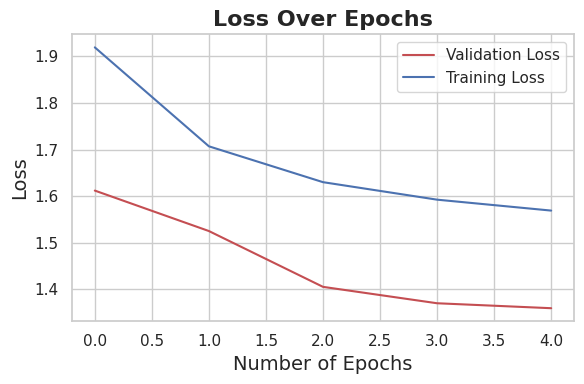

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

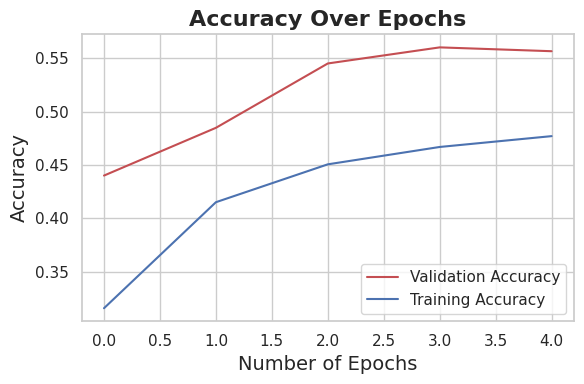

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
score = simplenn_model.evaluate(X_val, Y_val, verbose = 0)
print('Accuracy over the validation set:', round((score[1]*100), 2), '%')

Accuracy over the validation set: 55.68 %


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


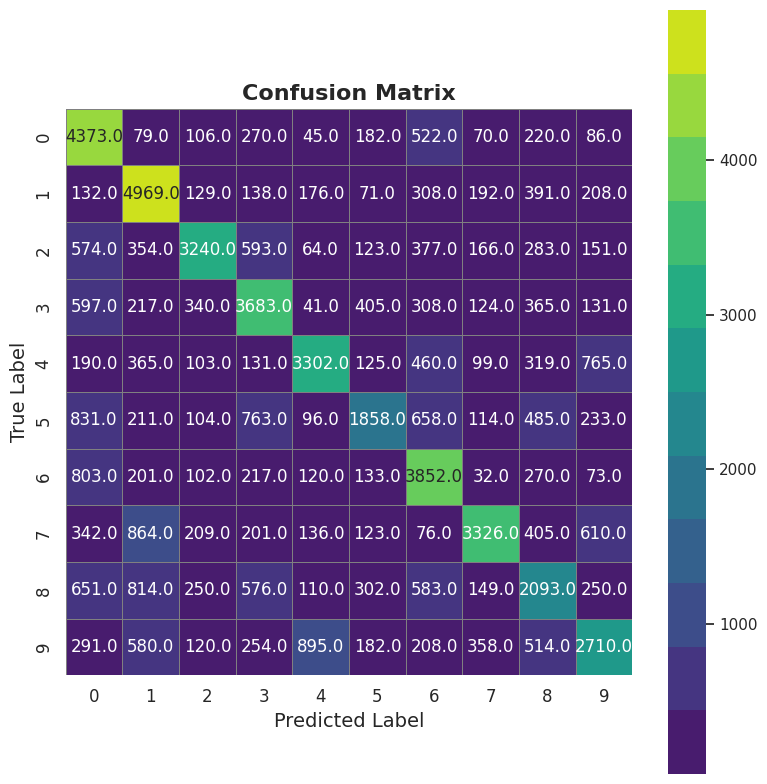

In [ ]:
# Predict the values from the validation dataset
Y_pred = simplenn_model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Create the plot
plt.figure(figsize=(8, 8))
# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)
# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
# Show the plot
plt.tight_layout()
plt.show()

**Observaciones 💡 -->**

Observamos que, al simplificar el modelo a solo un par de capas, la precisión ha disminuido significativamente, alcanzando apenas un 56%, lo que representa una pérdida de aproximadamente un 30% en comparación con modelos anteriores. Aunque esta simplificación ha resultado en un mayor número de errores, también ha reducido considerablemente el tiempo de entrenamiento.

### **(2) Modelo 2**

In [ ]:
second_simplenn_model = Sequential()
# Flatten layer to reshape 28x28x1 input into a 1D array of 784 elements
second_simplenn_model.add(Flatten(input_shape=(28, 28, 1)))
# Hidden layer with 64 neurons and ReLU activation
second_simplenn_model.add(Dense(128, activation='relu'))
# Output layer with 10 neurons (one for each class) and softmax activation
second_simplenn_model.add(Dense(10, activation='softmax'))

In [ ]:
# Compile the model
second_simplenn_model.compile(optimizer = opt, loss = "categorical_crossentropy" , metrics=["accuracy"])

In [ ]:
second_simplenn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

**Observaciones 💡 -->**

Al aumentar el número de neuronas en la capa oculta de 64 a 128 en el nuevo modelo, se incrementa la capacidad del modelo para aprender y representar características más complejas de las imágenes. A diferencia del modelo anterior, que contaba con una sola capa oculta de 64 neuronas, este modelo puede capturar más información y patrones sutiles en los datos de entrada, lo que podría mejorar la precisión del reconocimiento de imágenes. Sin embargo, esta mayor complejidad también podría resultar en un tiempo de entrenamiento más prolongado y un mayor riesgo de sobreajuste, este riesgo se analizará más adelante.

#### **(1) Entrenamiento**

In [ ]:
# Fit the model
history = second_simplenn_model.fit(datagen.flow(x_train_reshape, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 160s 17ms/step - accuracy: 0.2954 - loss: 1.9661 - val_accuracy: 0.5461 - val_loss: 1.3889
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 0.5076 - loss: 1.4879 - val_accuracy: 0.5903 - val_loss: 1.2302
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 0.5578 - loss: 1.3603 - val_accuracy: 0.6579 - val_loss: 1.0997
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 0.5789 - loss: 1.3082 - val_accuracy: 0.6629 - val_loss: 1.0628
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 201s 17ms/step - accuracy: 0.5932 - loss: 1.2702 - val_accuracy: 0.6817 - val_loss: 1.0387


#### **(2) Evaluación de Desempeño**

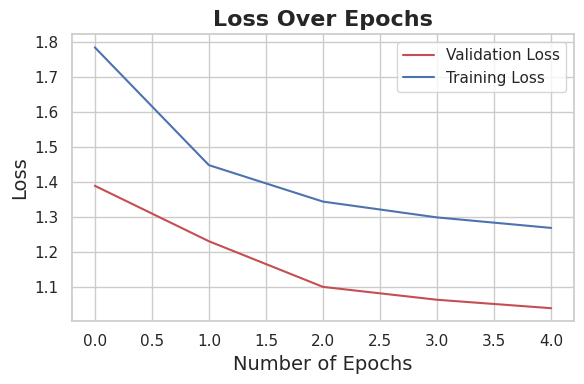

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

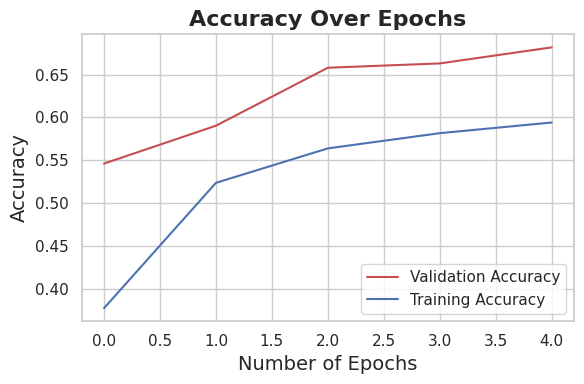

In [ ]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
score = second_simplenn_model.evaluate(X_val, Y_val, verbose = 0)
print('Accuracy over the validation set:', round((score[1]*100), 2), '%')

Accuracy over the validation set: 68.17 %


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


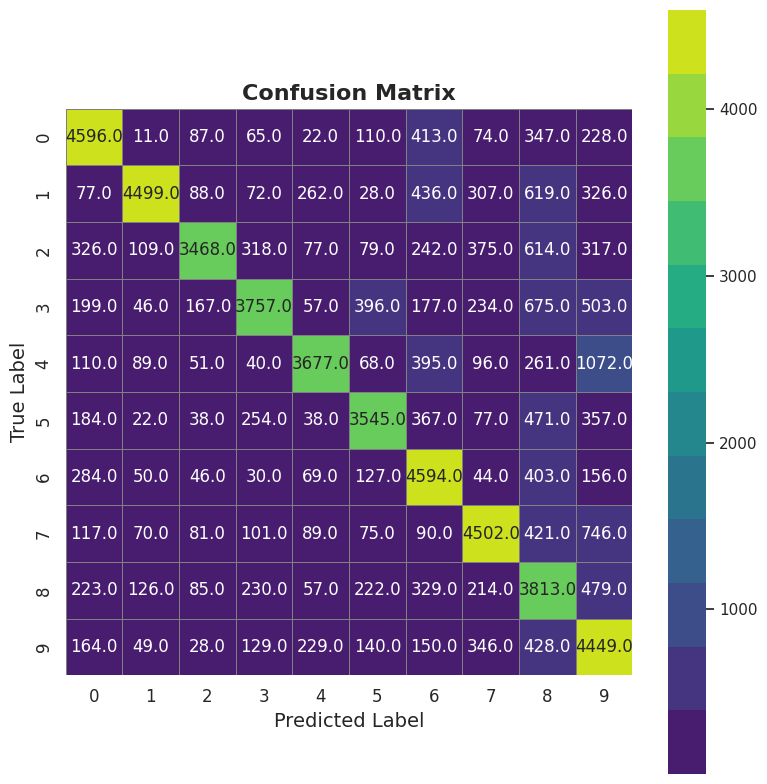

In [ ]:
# Predict the values from the validation dataset
Y_pred = second_simplenn_model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Create the plot
plt.figure(figsize=(8, 8))
# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)
# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
# Show the plot
plt.tight_layout()
plt.show()

**Observaciones 💡 -->**

Como era de esperarse, al incrementar el número de neuronas en la capa oculta de 64 a 128, el modelo ha demostrado una mayor capacidad para aprender y representar características complejas de las imágenes, lo que se traduce en un aumento significativo de la precisión, cercano al 13%. Sin embargo, este incremento en la capacidad de aprendizaje también ha dado lugar a un ligero sobreajuste en las primeras dos épocas de entrenamiento, además de un aumento en el tiempo de entrenamiento general. Aunque este modelo demuestra ser superior al anterior de redes neuronales simples, el primero modelo de deep learning elaborado continúa destacándose como el mejor. No solo ofrece una mayor precisión, sino que también mitiga eficazmente el sobreajuste y mantiene un tiempo de ejecución más eficiente.

### **(2) Evaluación de Prediccion de Modelos Generados**

In [ ]:
# Example prediction and expected class
model_prediction = simplenn_model.predict(img)
predicted_class = np.argmax(model_prediction)
expected_class = 3  # Expected class value

# Pretty print the result
print(f"First Model Prediction: {model_prediction}")
print(f"Predicted Class: {predicted_class}")
print(f"Expected Class: {expected_class}")

if predicted_class == expected_class:
    print(f"✅ The prediction is correct! The predicted class {predicted_class} matches the expected class.")
else:
    print(f"❌ The prediction is incorrect. The predicted class {predicted_class} does not match the expected class {expected_class}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
First Model Prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Predicted Class: 3
Expected Class: 3
✅ The prediction is correct! The predicted class 3 matches the expected class.


In [ ]:
# Example prediction and expected class
model_prediction = second_simplenn_model.predict(img)
predicted_class = np.argmax(model_prediction)
expected_class = 3  # Expected class value

# Pretty print the result
print(f"First Model Prediction: {model_prediction}")
print(f"Predicted Class: {predicted_class}")
print(f"Expected Class: {expected_class}")

if predicted_class == expected_class:
    print(f"✅ The prediction is correct! The predicted class {predicted_class} matches the expected class.")
else:
    print(f"❌ The prediction is incorrect. The predicted class {predicted_class} does not match the expected class {expected_class}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
First Model Prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Predicted Class: 3
Expected Class: 3
✅ The prediction is correct! The predicted class 3 matches the expected class.


## **Model Generation (Linear Classifier)**

### **(1) Modelo 1**

In [27]:
# Define the linear classifier model
linear_class = Sequential()
linear_class.add(Flatten(input_shape=(28, 28, 1)))
linear_class.add(Dense(10, activation='softmax'))

In [28]:
# Compile the model
linear_class.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
linear_class.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

**Observaciones 💡 -->**

Este es un modelo de clasificador lineal definido por una red neuronal secuencial con dos capas principales. Primero, la capa Flatten transforma las imágenes de entrada de tamaño 28x28 píxeles y un canal (escala de grises) en un vector unidimensional de 784 elementos, lo cual es necesario para procesar la información en una red densa. A continuación, la capa Dense con 10 unidades y función de activación softmax se encarga de generar una salida de 10 valores, cada uno representando la probabilidad de que la imagen pertenezca a una de las 10 clases posibles. La activación softmax asegura que las salidas se interpreten como probabilidades que suman 1. Este modelo se basa en el siguiente enlace: https://yann.lecun.com/exdb/mnist/

#### **(1) Entrenamiento**

In [30]:
# Fit the model
history = linear_class.fit(x_train_reshape, y_train, epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1405 - loss: 2.3423 - val_accuracy: 0.2613 - val_loss: 2.2404
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2792 - loss: 2.2242 - val_accuracy: 0.3219 - val_loss: 2.1879
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3329 - loss: 2.1764 - val_accuracy: 0.3582 - val_loss: 2.1573
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3641 - loss: 2.1492 - val_accuracy: 0.3842 - val_loss: 2.1396
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3859 - loss: 2.1330 - val_accuracy: 0.3986 - val_loss: 2.1284


#### **(2) Evaluación de Desempeño**

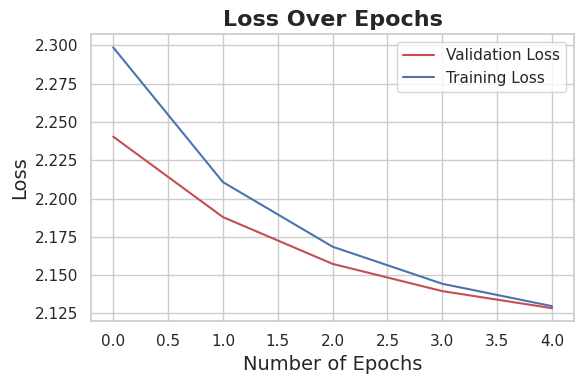

In [31]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

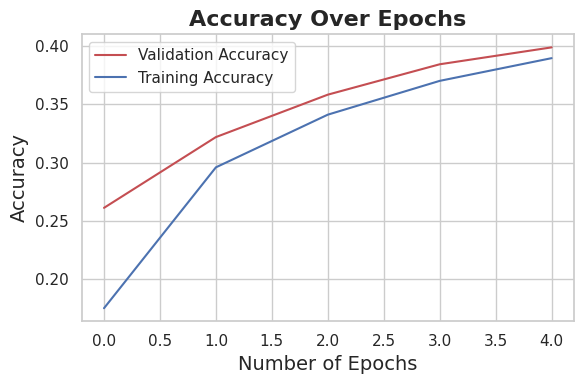

In [32]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [33]:
score = linear_class.evaluate(X_val, Y_val, verbose = 0)
print('Accuracy over the validation set:', round((score[1]*100), 2), '%')

Accuracy over the validation set: 39.86 %


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


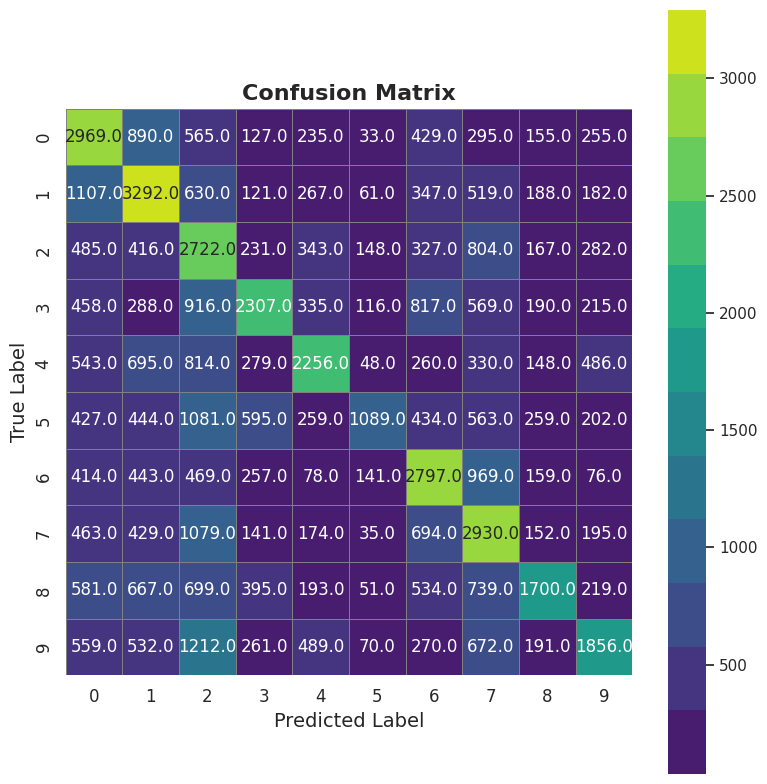

In [35]:
# Predict the values from the validation dataset
Y_pred = linear_class.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Create the plot
plt.figure(figsize=(8, 8))
# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)
# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
# Show the plot
plt.tight_layout()
plt.show()

**Observaciones 💡 -->**

Con una precisión del 39.86%, este modelo de clasificador lineal se presenta como una opción relativamente aceptable en términos de rendimiento. Aunque su precisión es moderada y no alcanza los estándares de modelos más avanzados, ofrece una ventaja significativa en términos de velocidad de entrenamiento, siendo el más rápido en comparación con los modelos previamente evaluados. Este balance entre rapidez en el entrenamiento y un rendimiento moderado puede ser útil en situaciones donde el tiempo es un factor crítico y se busca una solución rápida para obtener una estimación inicial. Sin embargo, para mejorar la precisión y obtener un modelo más robusto, vamos a probar utilizar la técnica de **data augmentation** que se ha probado en el resto de modelos hasta ahora. También es importante notar que presenta un leve sobreajuste en algunos puntos de su entrenamiento.

### **(2) Modelo 2 (Data Augmentation)**

#### **(1) Entrenamiento**

In [38]:
# Fit the model
history = linear_class.fit(datagen.flow(x_train_reshape, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val), batch_size = x_train_reshape.shape[0] // batch_size)

Epoch 1/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 166s 18ms/step - accuracy: 0.2365 - loss: 2.2635 - val_accuracy: 0.3261 - val_loss: 2.1961
Epoch 2/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 167s 18ms/step - accuracy: 0.2520 - loss: 2.2477 - val_accuracy: 0.3365 - val_loss: 2.1933
Epoch 3/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 164s 17ms/step - accuracy: 0.2520 - loss: 2.2468 - val_accuracy: 0.3597 - val_loss: 2.1543
Epoch 4/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 201s 17ms/step - accuracy: 0.2567 - loss: 2.2437 - val_accuracy: 0.3339 - val_loss: 2.1770
Epoch 5/5
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 163s 17ms/step - accuracy: 0.2544 - loss: 2.2449 - val_accuracy: 0.3448 - val_loss: 2.1779


#### **(2) Evaluación de Desempeño**

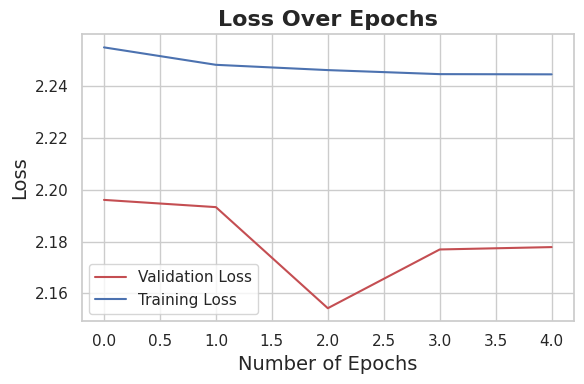

In [39]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], color='r', label="Validation Loss")
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], color='b', label="Training Loss")
# Add titles and labels with improved styling
plt.title("Loss Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

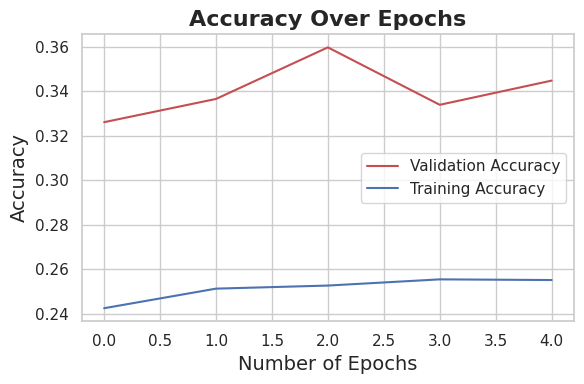

In [40]:
plt.figure(figsize=(6, 4))
# Plot train and validation loss with a color palette
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], color='r', label="Validation Accuracy")
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], color='b', label="Training Accuracy")
# Add titles and labels with improved styling
plt.title("Accuracy Over Epochs", fontsize=16, weight='bold')
plt.xlabel("Number of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# Add gridlines and legend
plt.grid(True)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

In [41]:
score = linear_class.evaluate(X_val, Y_val, verbose = 0)
print('Accuracy over the validation set:', round((score[1]*100), 2), '%')

Accuracy over the validation set: 34.48 %


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


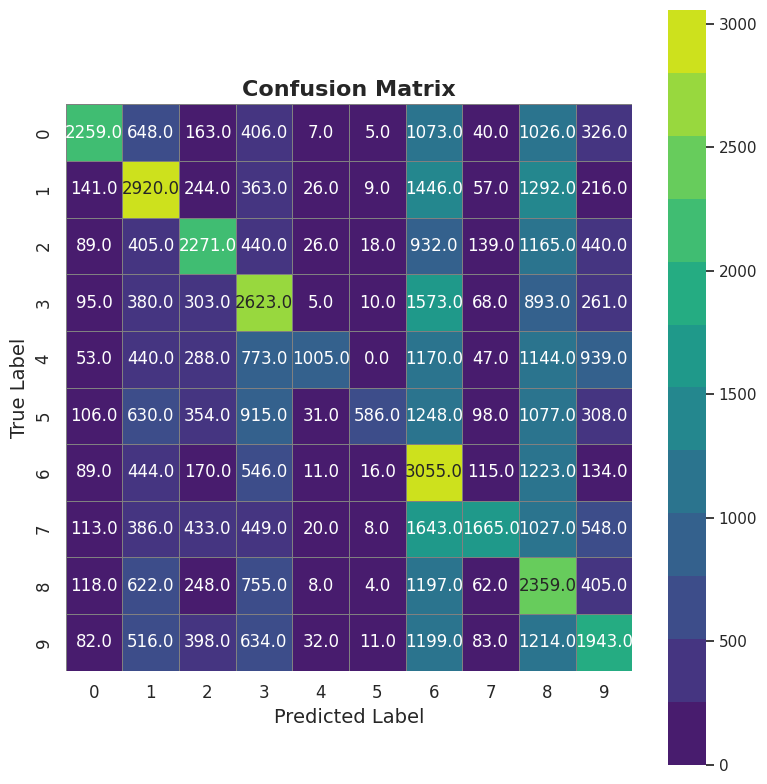

In [42]:
# Predict the values from the validation dataset
Y_pred = linear_class.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Create the plot
plt.figure(figsize=(8, 8))
# Plot the confusion matrix with a color palette
ax = sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap=palette, linewidths=0.5, linecolor='gray', square=True)
# Add titles and labels with improved styling
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
# Adjust tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
# Show the plot
plt.tight_layout()
plt.show()

**Observaciones 💡 -->**

> - Como se puede observar, la precisión ha disminuido drásticamente, teniendo ahora un valor de tan solo 34.48 %, alrededor de 6% menos en contraste con el modelo original. Se cree que para un clasificador lineal como este, la disminución en la precisión con la augmentación de datos puede deberse al hecho de que los modelos lineales son relativamente simples y pueden tener dificultades para capturar las complejidades introducidas por una augmentación. Los clasificadores lineales asumen una frontera de decisión lineal, y la augmentación excesiva puede distorsionar el espacio de características de maneras que el modelo lineal no puede separar efectivamente.

### **(2) Evaluación de Prediccion de Modelo Generado**

In [47]:
# Example prediction and expected class
model_prediction = linear_class.predict(img)
predicted_class = np.argmax(model_prediction)
expected_class = 3  # Expected class value

# Pretty print the result
print(f"Predicted Class: {predicted_class}")
print(f"Expected Class: {expected_class}")

if predicted_class == expected_class:
    print(f"✅ The prediction is correct! The predicted class {predicted_class} matches the expected class.")
else:
    print(f"❌ The prediction is incorrect. The predicted class {predicted_class} does not match the expected class {expected_class}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: 8
Expected Class: 3
❌ The prediction is incorrect. The predicted class 8 does not match the expected class 3.


## **Evaluating Different Models Preditions on Real-World Data** 🥇